In [197]:
import numpy as np
import pandas as pd
import os
import json
import warnings
import time
from datetime import datetime
from dataclasses import dataclass
from typing import Optional, List, Dict, Any

# Optuna for optimization
import optuna
from optuna.samplers import TPESampler

# MLForecast
from mlforecast import MLForecast
from mlforecast.auto import AutoMLForecast, AutoModel
from mlforecast.lag_transforms import (RollingMean, RollingStd, ExpandingMean,ExponentiallyWeightedMean,)

# Models
import lightgbm as lgb; import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Evaluation
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse, rmse

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*')
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

## General config

In [198]:
user = "lholguin"  # Your username for paths

# Paths
DATA_PATH = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\P1_ML.csv"
OUTPUT_PATH = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\"

# Target selection
TARGET = 'y_1'  # 'y' = Units Reimbursed, 'y_1' = Number of Prescriptions
TARGET_NAME = 'Units Reimbursed' if TARGET == 'y' else 'Number of Prescriptions'

# State filtering (None = all states)
STATES = ['IL']  # Options: None, ['IN'], ['IN', 'OH', 'IL', 'MI'], etc.

# Optimization settings
NUM_SAMPLES = 50  

In [199]:
@dataclass
class MLForecastConfig:
    
    # Target
    target_col: str = TARGET
    target_name: str = TARGET_NAME
    
    # Forecast parameters
    horizon: int = 8  # Quarters to forecast
    season_length: int = 4
    freq: str = 'QS'
    
    # Cross-validation
    n_windows: int = 2 # Look carefully at this since we have few observations. The reasonable maximum is 3 (if it runs ofc)
    step_size: int = 4  
    
    train_start: str = '2017-01-01'
    train_end: str = '2024-10-01'
    
    n_jobs: int = -1
    random_state: int = 42

config = MLForecastConfig()

## Section 1: Load Pre-Built Panel and Validate it

In [200]:
# Load pre-built panel
df = pd.read_csv(DATA_PATH)
df['ds'] = pd.to_datetime(df['ds'])

print(f"\nPanel Loaded: P1_ML.csv")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")

df.head()


Panel Loaded: P1_ML.csv
   Shape: (133414, 7)
   Columns: ['unique_id', 'ds', 'y', 'y_1', 'population', 'population_low', 'population_high']


,unique_id,ds,y,y_1,population,population_low,population_high
0,AK_A01,2017-01-01,36119.500,1235.0,180677.666667,NaN,NaN
1,AK_A01,2017-04-01,70157.400,2369.0,184889.333333,NaN,NaN
2,AK_A01,2017-07-01,58421.290,1624.0,184185.666667,NaN,NaN
3,AK_A01,2017-10-01,65281.208,2537.0,193784.666667,NaN,NaN
4,AK_A01,2018-01-01,50398.410,1365.0,196836.333333,NaN,NaN


In [201]:
# Filter states if specified
if STATES is not None:
    df['state'] = df['unique_id'].str.split('_').str[0]
    df = df[df['state'].isin(STATES)].copy()
    df = df.drop(columns=['state'])
    print(f"\nFiltered to states: {STATES}")
    print(f"   â€¢ Remaining series: {df['unique_id'].nunique()}")
    print(f"   â€¢ Remaining rows: {len(df):,}")
else:
    print(f"\nUsing all states")
    print(f"   â€¢ Total series: {df['unique_id'].nunique()}")


Filtered to states: ['IL']
   â€¢ Remaining series: 83
   â€¢ Remaining rows: 3,297


In [202]:
# Panel validation

print("\nPanel Validation:")
print("-" * 40)

required = ['unique_id', 'ds', 'y', 'population']
missing = [c for c in required if c not in df.columns]
print(f"Required columns: {'PASS' if not missing else f'FAIL - Missing: {missing}'}")

n_dups = df.groupby(['unique_id', 'ds']).size().gt(1).sum()
print(f"Duplicate check: {'PASS' if n_dups == 0 else f'FAIL - {n_dups} duplicates'}")

print(f"Missing 'y': {df['y'].isna().sum()}")
print(f"Missing 'population': {df['population'].isna().sum()}")


Panel Validation:
----------------------------------------
Required columns: PASS
Duplicate check: PASS
Missing 'y': 664
Missing 'population': 0


In [203]:
# Checking df for training

HISTORICAL_CUTOFF = pd.to_datetime(config.train_end)

df_historical = df[df['ds'] <= HISTORICAL_CUTOFF].copy()
df_future = df[df['ds'] > HISTORICAL_CUTOFF].copy()

print(f"\nData Split:")
print(f"  Historical: {len(df_historical):,} rows (up to {HISTORICAL_CUTOFF.strftime('%Y-%m-%d')})")
print(f"  Future: {len(df_future):,} rows")


Data Split:
  Historical: 2,633 rows (up to 2024-10-01)
  Future: 664 rows


In [204]:
#Dropping uncomplete series
print("\nBalancing Panel:")
print("-" * 40)

all_dates = sorted(df_historical['ds'].unique())
n_dates = len(all_dates)

series_lengths = df_historical.groupby('unique_id').size()
complete_series = series_lengths[series_lengths == n_dates].index

print(f"Total dates: {n_dates}")
print(f"Complete series: {len(complete_series)}")
print(f"Incomplete series: {len(series_lengths) - len(complete_series)} (removed)")

df_historical = df_historical[df_historical['unique_id'].isin(complete_series)].copy()
df_future = df_future[df_future['unique_id'].isin(complete_series)].copy()


Balancing Panel:
----------------------------------------
Total dates: 32
Complete series: 78
Incomplete series: 5 (removed)


In [205]:
# Create training dataframe
train_df = df_historical[['unique_id', 'ds', TARGET, 'population']].copy()
train_df.columns = ['unique_id', 'ds', 'y', 'population']
train_df = train_df.sort_values(['unique_id', 'ds']).reset_index(drop=True)

print(f"\nTraining DataFrame:")
print(f"  Shape: {train_df.shape}")
print(f"  Series: {train_df['unique_id'].nunique()}")
print(f"  Date range: {train_df['ds'].min().strftime('%Y-%m-%d')} to {train_df['ds'].max().strftime('%Y-%m-%d')}")

train_df.head()


Training DataFrame:
  Shape: (2496, 4)
  Series: 78
  Date range: 2017-01-01 to 2024-10-01


,unique_id,ds,y,population
0,IL_A01,2017-01-01,71551.0,2.904882e+06
1,IL_A01,2017-04-01,34123.0,2.878470e+06
2,IL_A01,2017-07-01,48156.0,2.833521e+06
3,IL_A01,2017-10-01,35163.0,2.884865e+06
4,IL_A01,2018-01-01,27582.0,2.901153e+06


In [206]:
# Create future exogenous dataframes
print("\nFuture Exogenous:")

if len(df_future) > 0 and df_future['population'].notna().any():
    X_future_point = df_future[['unique_id', 'ds', 'population']].copy()
    X_future_point = X_future_point.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_point: {X_future_point.shape}")
else:
    # Create from last known values
    print("  Creating from last known values...")
    last_date = train_df['ds'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), 
                                  periods=config.horizon, freq=config.freq)
    future_rows = []
    for uid in train_df['unique_id'].unique():
        last_pop = train_df[train_df['unique_id'] == uid]['population'].iloc[-1]
        for date in future_dates:
            future_rows.append({'unique_id': uid, 'ds': date, 'population': last_pop})
    X_future_point = pd.DataFrame(future_rows)
    print(f"  X_future_point: {X_future_point.shape}")

# Low/High scenarios
X_future_low = None
X_future_high = None

if 'population_low' in df_future.columns and df_future['population_low'].notna().any():
    X_future_low = df_future[['unique_id', 'ds', 'population_low']].copy()
    X_future_low.columns = ['unique_id', 'ds', 'population']
    X_future_low = X_future_low.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_low: {X_future_low.shape}")

if 'population_high' in df_future.columns and df_future['population_high'].notna().any():
    X_future_high = df_future[['unique_id', 'ds', 'population_high']].copy()
    X_future_high.columns = ['unique_id', 'ds', 'population']
    X_future_high = X_future_high.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_high: {X_future_high.shape}")


Future Exogenous:
  X_future_point: (624, 3)
  X_future_low: (624, 3)
  X_future_high: (624, 3)


## Section 2: Search Spaces for AutoMLForecast
#### AutoMLForecast from mlforecast library tunes:
1. Model parameters via `config` function (defined above) 
2. Features (lags,transforms) via `init_config` function

In [207]:
print("=" * 60); print("SECTION 2: DEFINE SEARCH SPACES"); print("=" * 60)

def lgb_config(trial: optuna.Trial) -> dict:
    """LightGBM hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbosity': -1,
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def xgb_config(trial: optuna.Trial) -> dict:
    """XGBoost hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbosity': 0,
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def rf_config(trial: optuna.Trial) -> dict:
    """RandomForest hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def ridge_config(trial: optuna.Trial) -> dict:
    """Ridge hyperparameter search space."""
    return {
        'alpha': trial.suggest_float('alpha', 1e-3, 100.0, log=True),
        'random_state': config.random_state,
    }

print("\nModel search spaces defined:")
print("  - LightGBM: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, ...")
print("  - XGBoost: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, gamma, ...")
print("  - RandomForest: n_estimators, max_depth, min_samples_leaf, ...")
print("  - Ridge: alpha")

SECTION 2: DEFINE SEARCH SPACES

Model search spaces defined:
  - LightGBM: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, ...
  - XGBoost: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, gamma, ...
  - RandomForest: n_estimators, max_depth, min_samples_leaf, ...
  - Ridge: alpha


In [208]:

def my_init_config(trial: optuna.Trial) -> dict:
    """
    Tune MLForecast features: lags and lag_transforms.
    This is called during optimization to find the best feature configuration.
    """
    # Tune lags
    use_lag_3 = trial.suggest_categorical('use_lag_3', [True, False])
    use_lag_8 = trial.suggest_categorical('use_lag_8', [True, False])
    
    lags = [1, 2, 4]  # Base lags
    #if use_lag_3:
        #lags.append(3)
    #if use_lag_8:
        #lags.append(8)
    #lags = sorted(lags)
    
    # Tune rolling window
    rolling_window = trial.suggest_categorical('rolling_window', [2, 4])
    
    # Tune expanding mean
    use_expanding = trial.suggest_categorical('use_expanding', [True, False])
    
    # Tune EWM
    use_ewm = trial.suggest_categorical('use_ewm', [True, False])
    ewm_alpha = trial.suggest_float('ewm_alpha', 0.1, 0.9) if use_ewm else 0.3
    
    # Build lag_transforms
    lag_transforms = {
        1: [RollingMean(window_size=rolling_window), RollingStd(window_size=rolling_window)],
    }
    
    if use_ewm:
        lag_transforms[1].append(ExponentiallyWeightedMean(alpha=ewm_alpha))
    
    if use_expanding:
        lag_transforms[4] = [ExpandingMean()]
    
    return {
        'lags': lags,
        'lag_transforms': lag_transforms,
        'date_features': ['quarter'],
    }

#This config is neccesary to avoid the error of missing fit parameters in static_features[] when running auto_mlf.fit()
def my_fit_config(trial: optuna.Trial) -> dict:
    """
    Parameters passed to MLForecast.fit()
    """
    return {
        'static_features': [],  # or ['unique_id'] or your static feature columns
        #'dropna': True  # Drop rows with NaNs after feature engineering
    }

print("\nFeature search space (init_config):")
print("  - Lags: [1,2,4] + optional [3,8]")
print("  - Rolling window: 2 or 4")
print("  - Expanding mean: True/False")
print("  - EWM: True/False with tunable alpha")


Feature search space (init_config):
  - Lags: [1,2,4] + optional [3,8]
  - Rolling window: 2 or 4
  - Expanding mean: True/False
  - EWM: True/False with tunable alpha


## Section 3: Run AutoMLForecast Optimization with Optuna

In [209]:
print("=" * 60); print("SECTION 3: AutoMLForecast OPTIMIZATION"); print("=" * 60)

# Create AutoModel instances
auto_lgb = AutoModel(model=lgb.LGBMRegressor(), config=lgb_config)
auto_xgb = AutoModel(model=xgb.XGBRegressor(), config=xgb_config)
auto_rf = AutoModel(model=RandomForestRegressor(), config=rf_config)
auto_ridge = AutoModel(model=Ridge(), config=ridge_config)

# Create AutoMLForecast
auto_mlf = AutoMLForecast(
    models={
        'LightGBM': auto_lgb,
        'XGBoost': auto_xgb,
        'RandomForest': auto_rf,
        'Ridge': auto_ridge,
    },
    freq=config.freq,
    season_length=config.season_length,
    init_config=my_init_config,
    fit_config=my_fit_config,
)

print("\nAutoMLForecast created:")
print(f"  Models: LightGBM, XGBoost, RandomForest, Ridge")
print(f"  Feature tuning: Enabled")

SECTION 3: AutoMLForecast OPTIMIZATION

AutoMLForecast created:
  Models: LightGBM, XGBoost, RandomForest, Ridge
  Feature tuning: Enabled


In [210]:
# Run optimization
print(f"\n{'='*60}")
print("RUNNING OPTIMIZATION")
print(f"{'='*60}")
print(f"  Trials per model: {NUM_SAMPLES}")
print(f"  CV windows: {config.n_windows}")
print(f"  Horizon: {config.horizon} quarters")
print(f"\n  This may take several minutes...\n")

start_time = time.time()

auto_mlf.fit(
    train_df,
    n_windows=config.n_windows,
    h=config.horizon,
    num_samples=NUM_SAMPLES,
)

elapsed = time.time() - start_time
print(f"\nOptimization complete!")
print(f"  Time: {elapsed/60:.1f} minutes")


RUNNING OPTIMIZATION
  Trials per model: 50
  CV windows: 2
  Horizon: 8 quarters

  This may take several minutes...


Optimization complete!
  Time: 0.7 minutes


## Section 4: Analyze Optimization Results

In [211]:
print("=" * 60); print("SECTION 4: OPTIMIZATION RESULTS"); print("=" * 60)

# Summary table
results_summary = []
for model_name, study in auto_mlf.results_.items():
    results_summary.append({
        'Model': model_name,
        'Best_CV_MAE': study.best_value,
        'Num_Trials': len(study.trials),
    })

results_df = pd.DataFrame(results_summary).sort_values('Best_CV_MAE')
best_model_name = results_df.iloc[0]['Model']
best_model_score = results_df.iloc[0]['Best_CV_MAE']

print("\nModel Comparison (sorted by CV MAE):")
print(results_df.to_string(index=False))
print(f"\nBest Model: {best_model_name} (MAE: {best_model_score:,.2f})")

SECTION 4: OPTIMIZATION RESULTS

Model Comparison (sorted by CV MAE):
       Model  Best_CV_MAE  Num_Trials
RandomForest     0.158938          50
    LightGBM     0.179041          50
     XGBoost     0.182025          50
       Ridge     0.534183          50

Best Model: RandomForest (MAE: 0.16)


In [212]:
# Best configurations
print("\n" + "=" * 60); print("BEST CONFIGURATIONS"); print("=" * 60)

best_configs = {}

for model_name, study in auto_mlf.results_.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    
    best_config = study.best_trial.user_attrs['config']
    best_configs[model_name] = best_config
    
    # Key model parameters
    model_params = best_config.get('model_params', {})
    key_params = ['n_estimators', 'max_depth', 'learning_rate', 'reg_alpha', 'reg_lambda', 'alpha']
    print("  Key params:")
    for k in key_params:
        if k in model_params:
            v = model_params[k]
            print(f"    {k}: {v:.4f}" if isinstance(v, float) else f"    {k}: {v}")
    
    # Features
    init_params = best_config.get('mlf_init_params', {})
    print(f"  Lags: {init_params.get('lags', 'default')}")
    print(f"  CV MAE: {study.best_value:,.2f}")


BEST CONFIGURATIONS

LightGBM:
----------------------------------------
  Key params:
    n_estimators: 261
    max_depth: 10
    learning_rate: 0.0206
    reg_alpha: 0.0058
    reg_lambda: 0.1041
  Lags: [1, 2, 4]
  CV MAE: 0.18

XGBoost:
----------------------------------------
  Key params:
    n_estimators: 367
    max_depth: 8
    learning_rate: 0.0220
    reg_alpha: 0.0000
    reg_lambda: 0.0514
  Lags: [1, 2, 4]
  CV MAE: 0.18

RandomForest:
----------------------------------------
  Key params:
    n_estimators: 335
    max_depth: 8
  Lags: [1, 2, 4]
  CV MAE: 0.16

Ridge:
----------------------------------------
  Key params:
    alpha: 0.3979
  Lags: [1, 2, 4]
  CV MAE: 0.53


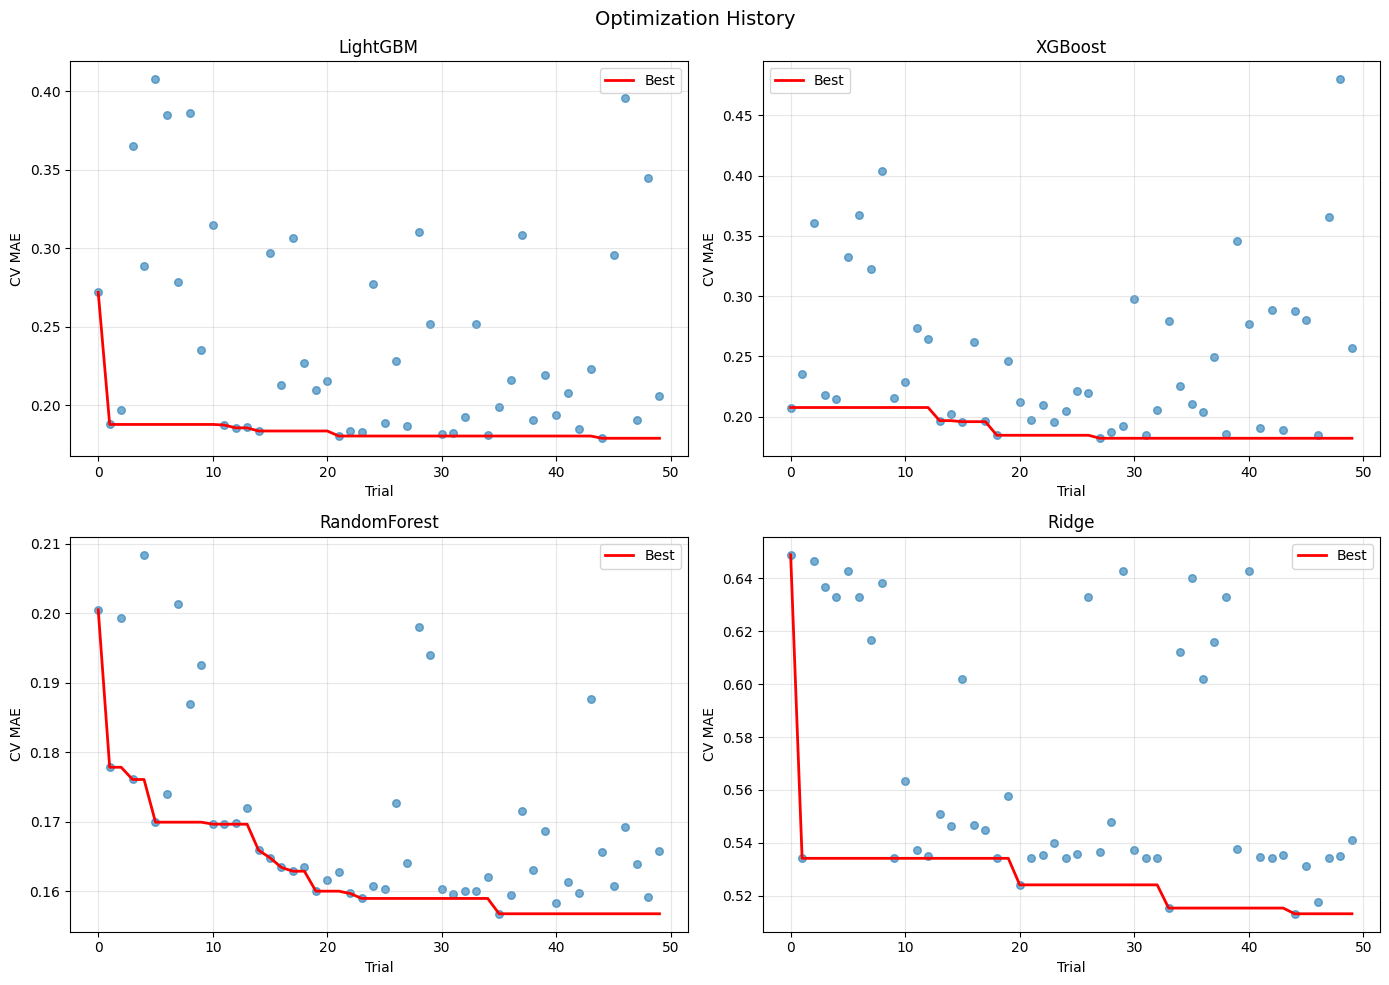

In [213]:
# Optimization history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (model_name, study) in enumerate(auto_mlf.results_.items()):
    if idx >= 4:
        break
    ax = axes[idx]
    
    trial_values = [t.value for t in study.trials]
    ax.scatter(range(len(trial_values)), trial_values, alpha=0.6, s=30)
    
    # Best so far line
    best_so_far = [min(trial_values[:i+1]) for i in range(len(trial_values))]
    ax.plot(range(len(best_so_far)), best_so_far, 'r-', linewidth=2, label='Best')
    
    ax.set_xlabel('Trial')
    ax.set_ylabel('CV MAE')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Optimization History', fontsize=14)
plt.tight_layout()
plt.show()

## Section 5: Generating Forecasts

In [214]:
print("=" * 60); print("SECTION 5: GENERATE FORECASTS"); print("=" * 60)

print("\nFitted Models:")
for model_name in auto_mlf.models_.keys():
    print(f"  - {model_name}")

SECTION 5: GENERATE FORECASTS

Fitted Models:
  - LightGBM
  - XGBoost
  - RandomForest
  - Ridge


In [215]:
# Generate forecasts
print("\nGenerating forecasts (Point Scenario)...")

print("\nâš ï¸  Refitting models after cross-validation...")

for model_name, mlf in auto_mlf.models_.items():
    print(f"  Refitting {model_name}...", end=" ")
    mlf.fit(
        df=train_df,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        static_features=[],
    )
    print("âœ“")

print("\nâœ… All models refitted! Ready to generate forecasts.\n")

forecasts_point = auto_mlf.predict(h=config.horizon, X_df=X_future_point)

print(f"  Shape: {forecasts_point.shape}")
print(f"  Models: {[c for c in forecasts_point.columns if c not in ['unique_id', 'ds']]}")

forecasts_point.head(15)


Generating forecasts (Point Scenario)...

âš ï¸  Refitting models after cross-validation...
  Refitting LightGBM... âœ“
  Refitting XGBoost... âœ“
  Refitting RandomForest... âœ“
  Refitting Ridge... âœ“

âœ… All models refitted! Ready to generate forecasts.

  Shape: (624, 6)
  Models: ['LightGBM', 'XGBoost', 'RandomForest', 'Ridge']


,unique_id,ds,LightGBM,XGBoost,RandomForest,Ridge
0,IL_A01,2025-01-01,24361.673791,24954.515625,29098.636586,13213.383970
1,IL_A01,2025-04-01,25655.657222,26040.482422,34631.193458,12414.185027
2,IL_A01,2025-07-01,26467.744188,30483.021484,39409.836010,14733.738806
3,IL_A01,2025-10-01,33338.577303,36536.535156,40745.583620,21211.500838
4,IL_A01,2026-01-01,43301.556980,45847.785156,45308.657279,29598.791241
5,IL_A01,2026-04-01,42390.926217,42212.597656,47343.526754,37428.764271
6,IL_A01,2026-07-01,40699.945008,39078.136719,50031.179937,44598.691865
7,IL_A01,2026-10-01,45332.346719,37774.785156,52500.759697,50787.558397
8,IL_A02,2025-01-01,129433.112649,126205.968750,146262.979091,120296.929928
9,IL_A02,2025-04-01,121064.122266,116765.156250,141232.542755,114698.538925


In [216]:
# Low/High scenarios
forecasts_low = None
forecasts_high = None

if X_future_low is not None:
    print("\nGenerating forecasts (Low Scenario)...")
    forecasts_low = auto_mlf.predict(h=config.horizon, X_df=X_future_low)
    print(f"  Shape: {forecasts_low.shape}")

if X_future_high is not None:
    print("\nGenerating forecasts (High Scenario)...")
    forecasts_high = auto_mlf.predict(h=config.horizon, X_df=X_future_high)
    print(f"  Shape: {forecasts_high.shape}")


Generating forecasts (Low Scenario)...
  Shape: (624, 6)

Generating forecasts (High Scenario)...
  Shape: (624, 6)


In [217]:
# Create ensemble
print("\nCreating Ensemble (weighted by inverse MAE)...")

model_cols = [c for c in forecasts_point.columns if c not in ['unique_id', 'ds']]

weights = {}
for model_name in model_cols:
    if model_name in auto_mlf.results_:
        weights[model_name] = 1.0 / auto_mlf.results_[model_name].best_value

total = sum(weights.values())
weights = {k: v/total for k, v in weights.items()}

print("  Weights:")
for m, w in sorted(weights.items(), key=lambda x: -x[1]):
    print(f"    {m}: {w:.2%}")

forecasts_point['Ensemble'] = sum(forecasts_point[m] * w for m, w in weights.items())
print("\n  Ensemble added!")


Creating Ensemble (weighted by inverse MAE)...
  Weights:
    RandomForest: 32.70%
    LightGBM: 29.03%
    XGBoost: 28.55%
    Ridge: 9.73%

  Ensemble added!


## Section 7: Save Results

In [218]:
print("=" * 60)
print("SECTION 7: SAVE RESULTS")
print("=" * 60)

os.makedirs(OUTPUT_PATH, exist_ok=True)

# Forecasts
forecasts_point.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_point.csv'), index=False)
print(f"Saved: {TARGET}_forecasts_point.csv")

if forecasts_low is not None:
    forecasts_low.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_low.csv'), index=False)
    print(f"Saved: {TARGET}_forecasts_low.csv")

if forecasts_high is not None:
    forecasts_high.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_high.csv'), index=False)
    print(f"Saved: {TARGET}_forecasts_high.csv")

# Model comparison
#results_df.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_model_comparison.csv'), index=False)
#print(f"Saved: {TARGET}_model_comparison.csv")

# Best configs
configs_to_save = {}
for model_name, cfg in best_configs.items():
    model_params = cfg.get('model_params', {})
    init_params = cfg.get('mlf_init_params', {})
    configs_to_save[model_name] = {
        'model_params': {k: v for k, v in model_params.items() 
                        if k not in ['verbosity', 'random_state', 'n_jobs']},
        'lags': init_params.get('lags'),
        'cv_mae': auto_mlf.results_[model_name].best_value,
    }

with open(os.path.join(OUTPUT_PATH, f'{TARGET}_best_configs.json'), 'w') as f:
    json.dump(configs_to_save, f, indent=2, default=str)
print(f"Saved: {TARGET}_best_configs.json")

# Models
try:
    models_path = os.path.join(OUTPUT_PATH, 'models')
    auto_mlf.save(models_path)
    print(f"Saved: models/ directory")
except Exception as e:
    print(f"Note: Could not save models: {e}")

SECTION 7: SAVE RESULTS
Saved: y_1_forecasts_point.csv
Saved: y_1_forecasts_low.csv
Saved: y_1_forecasts_high.csv
Saved: y_1_best_configs.json
Saved: models/ directory


---
## Section 8: Best Model Selection Per Series & Plotting

Two new functions:
1. **`select_best_model_per_series_ml()`** - Selects best ML model per unique_id based on CV consistency
2. **`plot_forecast_with_intervals()`** - Plots historical + forecast with population scenario intervals

In [219]:
def select_best_model_per_series_ml(
    auto_mlf,
    train_df: pd.DataFrame,
    forecasts_point: pd.DataFrame,
    forecasts_low: pd.DataFrame = None,
    forecasts_high: pd.DataFrame = None,
    config = None,
    horizon: int = 8,
    n_windows: int = 2,
    consistency_threshold: float = 0.5,
    save_path: str = None
) -> dict:
    
    print("=" * 70)
    print(f"BEST MODEL SELECTION PER SERIES (Horizon={horizon})")
    print("=" * 70)
    
    model_names = list(auto_mlf.models_.keys())
    print(f"\nModels: {model_names}")
    print(f"Series: {train_df['unique_id'].nunique()}")
    
    # Get step_size from config or default
    step_size = config.step_size if config else 4
    
    print(f"\n🔄 Phase 1: Cross-Validation (n_windows={n_windows})...")
    
    cv_results = {}
    for model_name, mlf in auto_mlf.models_.items():
        print(f"   CV for {model_name}...", end=" ")
        try:
            cv_df = mlf.cross_validation(
                df=train_df,
                h=horizon,
                n_windows=n_windows,
                step_size=step_size,
                static_features=[],
            )
            cv_results[model_name] = cv_df
            print(f"✓ ({len(cv_df)} rows)")
        except Exception as e:
            print(f"✗ Error: {e}")
            continue
    
    if not cv_results:
        raise ValueError("No CV results obtained. Check your data.")
    
    # Merge CV results
    first_model = list(cv_results.keys())[0]
    merged_cv = cv_results[first_model][['unique_id', 'ds', 'y', 'cutoff']].copy()
    for model_name in cv_results:
        merged_cv[model_name] = cv_results[model_name][model_name]
    
    print(f"\n🎯 Phase 2: Selecting best model per series...")
    
    cv_windows = merged_cv['cutoff'].unique()
    available_models = list(cv_results.keys())
    
    best_model_selection = []
    
    for uid in train_df['unique_id'].unique():
        uid_cv = merged_cv[merged_cv['unique_id'] == uid]
        
        if len(uid_cv) == 0:
            continue
        
        # Count wins per model across CV windows (based on MAE)
        model_wins = {m: 0 for m in available_models}
        model_maes = {m: [] for m in available_models}
        
        for cutoff in cv_windows:
            cutoff_data = uid_cv[uid_cv['cutoff'] == cutoff]
            if len(cutoff_data) == 0:
                continue
            
            # Calculate MAE for each model in this window
            window_maes = {}
            for model in available_models:
                if model in cutoff_data.columns:
                    mae_val = np.mean(np.abs(cutoff_data['y'] - cutoff_data[model]))
                    window_maes[model] = mae_val
                    model_maes[model].append(mae_val)
            
            # Find winner for this window
            if window_maes:
                winner = min(window_maes, key=window_maes.get)
                model_wins[winner] += 1
        
        # Select model with most wins
        total_windows = len(cv_windows)
        best_model = max(model_wins, key=model_wins.get)
        win_count = model_wins[best_model]
        consistency_ratio = win_count / total_windows if total_windows > 0 else 0
        
        # Average MAE for best model
        avg_mae = np.mean(model_maes[best_model]) if model_maes[best_model] else np.nan
        
        # Confidence level
        if consistency_ratio >= 0.8:
            confidence = 'High'
        elif consistency_ratio >= consistency_threshold:
            confidence = 'Medium'
        else:
            confidence = 'Low'
        
        best_model_selection.append({
            'unique_id': uid,
            'best_model': best_model,
            'consistency_ratio': consistency_ratio,
            'confidence': confidence,
            'win_count': win_count,
            'n_windows': total_windows,
            'avg_mae': avg_mae,
        })
    
    best_model_df = pd.DataFrame(best_model_selection)
    
    print(f"\n   Model Distribution:")
    print(f"   {best_model_df['best_model'].value_counts().to_dict()}")
    print(f"   Confidence: {best_model_df['confidence'].value_counts().to_dict()}")

    print(f"\n🔮 Phase 3: Building forecasts from existing predictions...")
    
    final_rows = []
    
    for uid in train_df['unique_id'].unique():
        uid_best = best_model_df[best_model_df['unique_id'] == uid]
        if len(uid_best) == 0:
            continue
        
        best_model = uid_best['best_model'].iloc[0]
        confidence = uid_best['confidence'].iloc[0]
        consistency = uid_best['consistency_ratio'].iloc[0]
        
        # Get point forecasts for this series
        uid_point = forecasts_point[forecasts_point['unique_id'] == uid]
        
        for _, row in uid_point.iterrows():
            output = {
                'unique_id': uid,
                'ds': row['ds'],
                'best_model': best_model,
                'confidence': confidence,
                'consistency_ratio': consistency,
                'forecast_point': row[best_model] if best_model in row.index else np.nan,
            }
            
            # Add low scenario if available
            if forecasts_low is not None:
                uid_low = forecasts_low[(forecasts_low['unique_id'] == uid) & 
                                        (forecasts_low['ds'] == row['ds'])]
                if len(uid_low) > 0 and best_model in uid_low.columns:
                    output['forecast_low_pop'] = uid_low[best_model].iloc[0]
                else:
                    output['forecast_low_pop'] = np.nan
            else:
                output['forecast_low_pop'] = np.nan
            
            # Add high scenario if available
            if forecasts_high is not None:
                uid_high = forecasts_high[(forecasts_high['unique_id'] == uid) & 
                                          (forecasts_high['ds'] == row['ds'])]
                if len(uid_high) > 0 and best_model in uid_high.columns:
                    output['forecast_high_pop'] = uid_high[best_model].iloc[0]
                else:
                    output['forecast_high_pop'] = np.nan
            else:
                output['forecast_high_pop'] = np.nan
            
            final_rows.append(output)
    
    final_df = pd.DataFrame(final_rows)
    
    print(f"   Generated {len(final_df)} forecast rows")
    
    # Save
    if save_path:
        os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
        final_df.to_csv(save_path, index=False)
        print(f"\n✅ Saved forecasts: {save_path}")
        
        sel_path = save_path.replace('.csv', '_model_selection.csv')
        best_model_df.to_csv(sel_path, index=False)
        print(f"✅ Saved model selection: {sel_path}")
    
    print(f"\n{'='*70}")
    print(f"✅ COMPLETE! Series: {final_df['unique_id'].nunique()}, Periods: {final_df['ds'].nunique()}")
    print(f"{'='*70}")
    
    return {
        'best_model_df': best_model_df,
        'combined_forecasts': final_df,
        'historical_data': train_df,
    }

In [220]:
HIST_COLOR = "#898992"

def plot_forecast_with_intervals(
    historical_df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    unique_id: str,
    target_name: str = 'Units Reimbursed',
    show_scenarios: bool = True,
    figsize: tuple = (14, 8),
    save_path: str = None
):
      
    hist = historical_df[historical_df['unique_id'] == unique_id].copy()
    fore = forecast_df[forecast_df['unique_id'] == unique_id].copy()
    
    if len(hist) == 0 or len(fore) == 0:
        print(f"No data for {unique_id}")
        return None
    
    hist['ds'] = pd.to_datetime(hist['ds'])
    fore['ds'] = pd.to_datetime(fore['ds'])
    hist = hist.sort_values('ds')
    fore = fore.sort_values('ds')
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scale
    max_val = max(hist['y'].max(), fore['forecast_point'].max())
    scale = 1e6 if max_val > 1e6 else 1e3 if max_val > 1e3 else 1
    label = 'Millions' if scale == 1e6 else 'Thousands' if scale == 1e3 else ''
    
    # Historical
    ax.plot(hist['ds'], hist['y']/scale, color=HIST_COLOR, lw=2.5, 
            marker='o', ms=6, label='Historical', zorder=10)
    
    last = hist.iloc[-1]
    
    # Connection line
    ax.plot([last['ds'], fore['ds'].iloc[0]], 
            [last['y']/scale, fore['forecast_point'].iloc[0]/scale],
            color='#E94F37', lw=2, ls='--', alpha=0.7)
    
    # Point forecast
    ax.plot(fore['ds'], fore['forecast_point']/scale, color='#E94F37', 
            lw=2.5, marker='s', ms=6, ls='--', label='Point Forecast', zorder=9)
    
    # Population scenarios
    if show_scenarios and 'forecast_low_pop' in fore.columns:
        ax.fill_between(fore['ds'], 
                       fore['forecast_low_pop']/scale,
                       fore['forecast_high_pop']/scale,
                       color='#9B59B6', alpha=0.2, label='Pop. Scenario Range', zorder=5)
        ax.plot(fore['ds'], fore['forecast_low_pop']/scale,
               color='#2E86AB', lw=1.5, ls=':', marker='^', ms=4, 
               label='Low Pop.', alpha=0.7, zorder=8)
        ax.plot(fore['ds'], fore['forecast_high_pop']/scale,
               color='#28A745', lw=1.5, ls=':', marker='v', ms=4,
               label='High Pop.', alpha=0.7, zorder=8)
    
    ax.axvline(x=last['ds'], color='gray', ls=':', lw=2, alpha=0.7)
    
    # Title with model info
    model = fore['best_model'].iloc[0] if 'best_model' in fore.columns else ''
    conf = fore['confidence'].iloc[0] if 'confidence' in fore.columns else ''
    cons = fore['consistency_ratio'].iloc[0] if 'consistency_ratio' in fore.columns else 0
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(f'{target_name} ({label})' if label else target_name, fontsize=12)
    ax.set_title(f'{unique_id}: {target_name}\nModel: {model} | Confidence: {conf} | Consistency: {cons:.0%}',
                fontsize=14, fontweight='bold')
    
    ax.legend(loc='upper left', fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


def plot_multiple_forecasts(
    historical_df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    unique_ids: list = None,
    n_random: int = 6,
    target_name: str = 'Units Reimbursed',
    figsize: tuple = (16, 12)
):
    """Plot multiple series in a grid."""
    
    if unique_ids is None:
        all_ids = forecast_df['unique_id'].unique()
        unique_ids = np.random.choice(all_ids, min(n_random, len(all_ids)), replace=False)
    
    n = len(unique_ids)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    for i, uid in enumerate(unique_ids):
        ax = axes[i]
        
        hist = historical_df[historical_df['unique_id'] == uid].copy()
        fore = forecast_df[forecast_df['unique_id'] == uid].copy()
        
        if len(hist) == 0 or len(fore) == 0:
            ax.set_visible(False)
            continue
        
        hist['ds'] = pd.to_datetime(hist['ds'])
        fore['ds'] = pd.to_datetime(fore['ds'])
        hist = hist.sort_values('ds')
        fore = fore.sort_values('ds')
        
        max_val = max(hist['y'].max(), fore['forecast_point'].max())
        scale = 1e6 if max_val > 1e6 else 1e3 if max_val > 1e3 else 1
        
        ax.plot(hist['ds'], hist['y']/scale, color=HIST_COLOR, lw=1.5, marker='o', ms=3)
        
        last = hist.iloc[-1]
        ax.plot([last['ds'], fore['ds'].iloc[0]], 
                [last['y']/scale, fore['forecast_point'].iloc[0]/scale],
                color='#E94F37', lw=1.5, ls='--', alpha=0.7)
        ax.plot(fore['ds'], fore['forecast_point']/scale, 
                color='#E94F37', lw=1.5, marker='s', ms=3, ls='--')
        
        if 'forecast_low_pop' in fore.columns:
            ax.fill_between(fore['ds'], fore['forecast_low_pop']/scale,
                           fore['forecast_high_pop']/scale, color='#9B59B6', alpha=0.15)
        
        ax.axvline(x=last['ds'], color='gray', ls=':', alpha=0.5)
        
        model = fore['best_model'].iloc[0] if 'best_model' in fore.columns else ''
        conf = fore['confidence'].iloc[0] if 'confidence' in fore.columns else ''
        ax.set_title(f'{uid}\n{model} ({conf})', fontsize=9, fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.grid(True, alpha=0.3)
    
    for i in range(len(unique_ids), len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'{target_name} Forecasts', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    return fig

### Run Best Model Selection

In [221]:
# Run best model selection using:
# - auto_mlf: the fitted AutoMLForecast
# - forecasts_point, forecasts_low, forecasts_high: already generated in Section 5

results = select_best_model_per_series_ml(
    auto_mlf=auto_mlf,
    train_df=train_df,
    forecasts_point=forecasts_point,
    forecasts_low=forecasts_low,
    forecasts_high=forecasts_high,
    config=config,
    horizon=8,
    n_windows=2,
    consistency_threshold=0.5,
    save_path=os.path.join(OUTPUT_PATH, 'best_model_forecasts.csv')
)

BEST MODEL SELECTION PER SERIES (Horizon=8)

Models: ['LightGBM', 'XGBoost', 'RandomForest', 'Ridge']
Series: 78

🔄 Phase 1: Cross-Validation (n_windows=2)...
   CV for LightGBM... ✓ (1248 rows)
   CV for XGBoost... ✓ (1248 rows)
   CV for RandomForest... ✓ (1248 rows)
   CV for Ridge... ✓ (1248 rows)

🎯 Phase 2: Selecting best model per series...

   Model Distribution:
   {'XGBoost': 30, 'LightGBM': 28, 'RandomForest': 18, 'Ridge': 2}
   Confidence: {'Medium': 48, 'High': 30}

🔮 Phase 3: Building forecasts from existing predictions...
   Generated 624 forecast rows

✅ Saved forecasts: C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\best_model_forecasts.csv
✅ Saved model selection: C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\best_model_forecasts_model_selection.csv

✅ COMPLETE! Series: 78, Periods: 8


In [222]:
# View results
print("Model Selection Summary:")
print(results['best_model_df']['best_model'].value_counts())
print("\nConfidence Distribution:")
print(results['best_model_df']['confidence'].value_counts())
print("\nSample Forecasts:")
results['combined_forecasts'].head(10)

Model Selection Summary:
best_model
XGBoost         30
LightGBM        28
RandomForest    18
Ridge            2
Name: count, dtype: int64

Confidence Distribution:
confidence
Medium    48
High      30
Name: count, dtype: int64

Sample Forecasts:


,unique_id,ds,best_model,confidence,consistency_ratio,forecast_point,forecast_low_pop,forecast_high_pop
0,IL_A01,2025-01-01,LightGBM,Medium,0.5,24361.673791,25418.074228,26024.053095
1,IL_A01,2025-04-01,LightGBM,Medium,0.5,25655.657222,27635.015437,28851.742320
2,IL_A01,2025-07-01,LightGBM,Medium,0.5,26467.744188,35732.037557,34314.654293
3,IL_A01,2025-10-01,LightGBM,Medium,0.5,33338.577303,40796.399800,39420.346746
4,IL_A01,2026-01-01,LightGBM,Medium,0.5,43301.556980,44561.081989,47851.392965
5,IL_A01,2026-04-01,LightGBM,Medium,0.5,42390.926217,46737.370762,49197.780507
6,IL_A01,2026-07-01,LightGBM,Medium,0.5,40699.945008,53172.927091,50369.576883
7,IL_A01,2026-10-01,LightGBM,Medium,0.5,45332.346719,57537.235045,55039.209113
8,IL_A02,2025-01-01,XGBoost,Medium,0.5,126205.968750,131122.281250,133055.734375
9,IL_A02,2025-04-01,XGBoost,Medium,0.5,116765.156250,131741.265625,124578.562500


### Plot Forecasts

Plotting: IL_A01


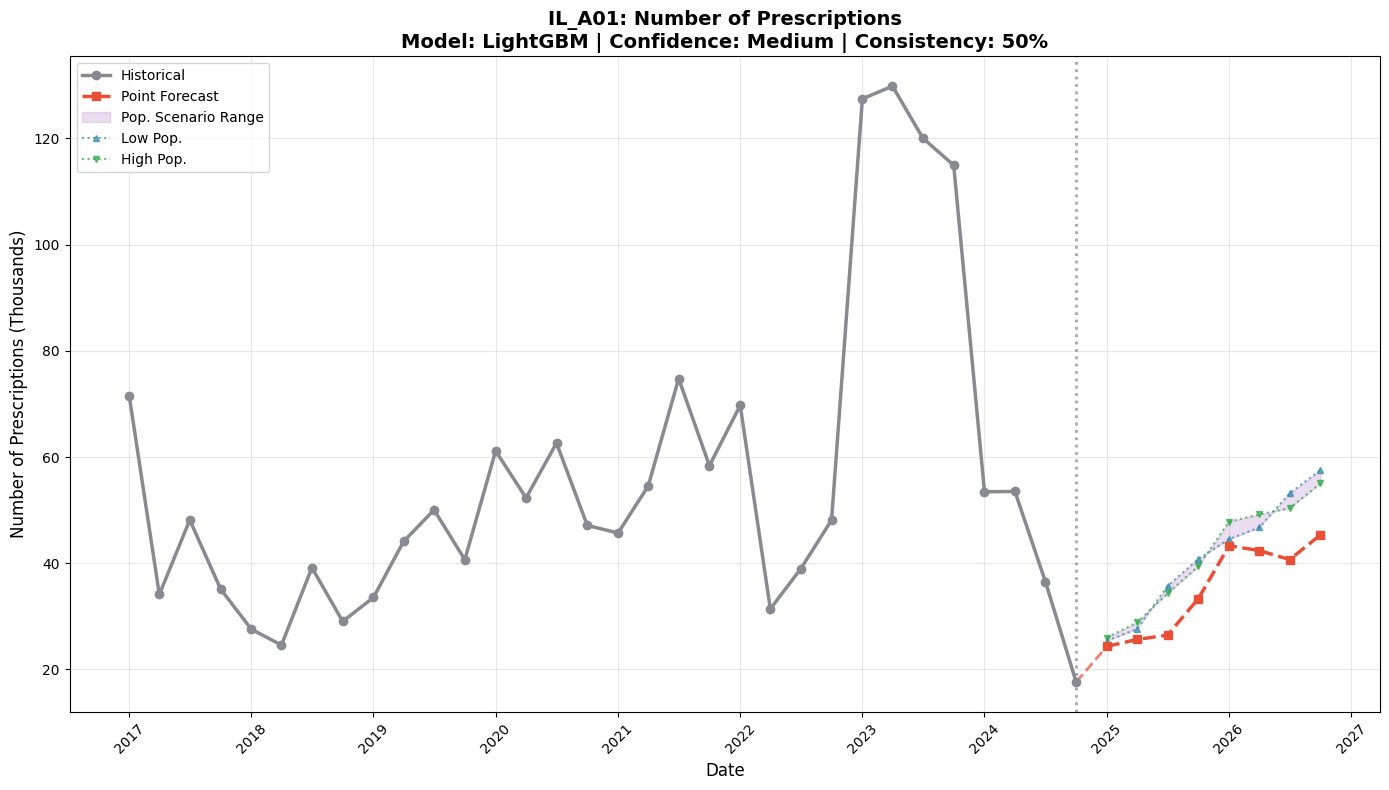

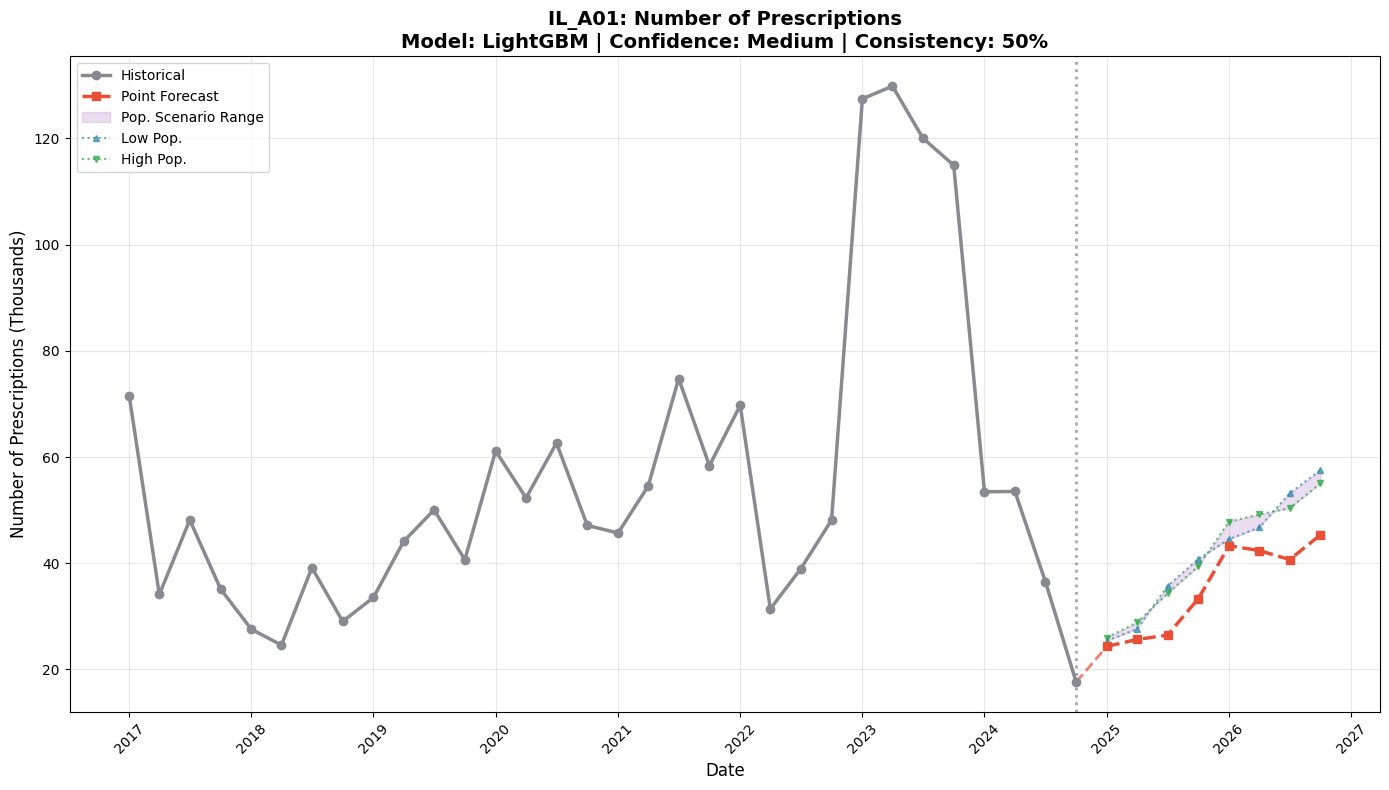

In [223]:
# Plot a single series
sample_id = results['combined_forecasts']['unique_id'].iloc[0]
print(f"Plotting: {sample_id}")

plot_forecast_with_intervals(
    historical_df=results['historical_data'],
    forecast_df=results['combined_forecasts'],
    unique_id=sample_id,
    target_name=TARGET_NAME,
    show_scenarios=True
)

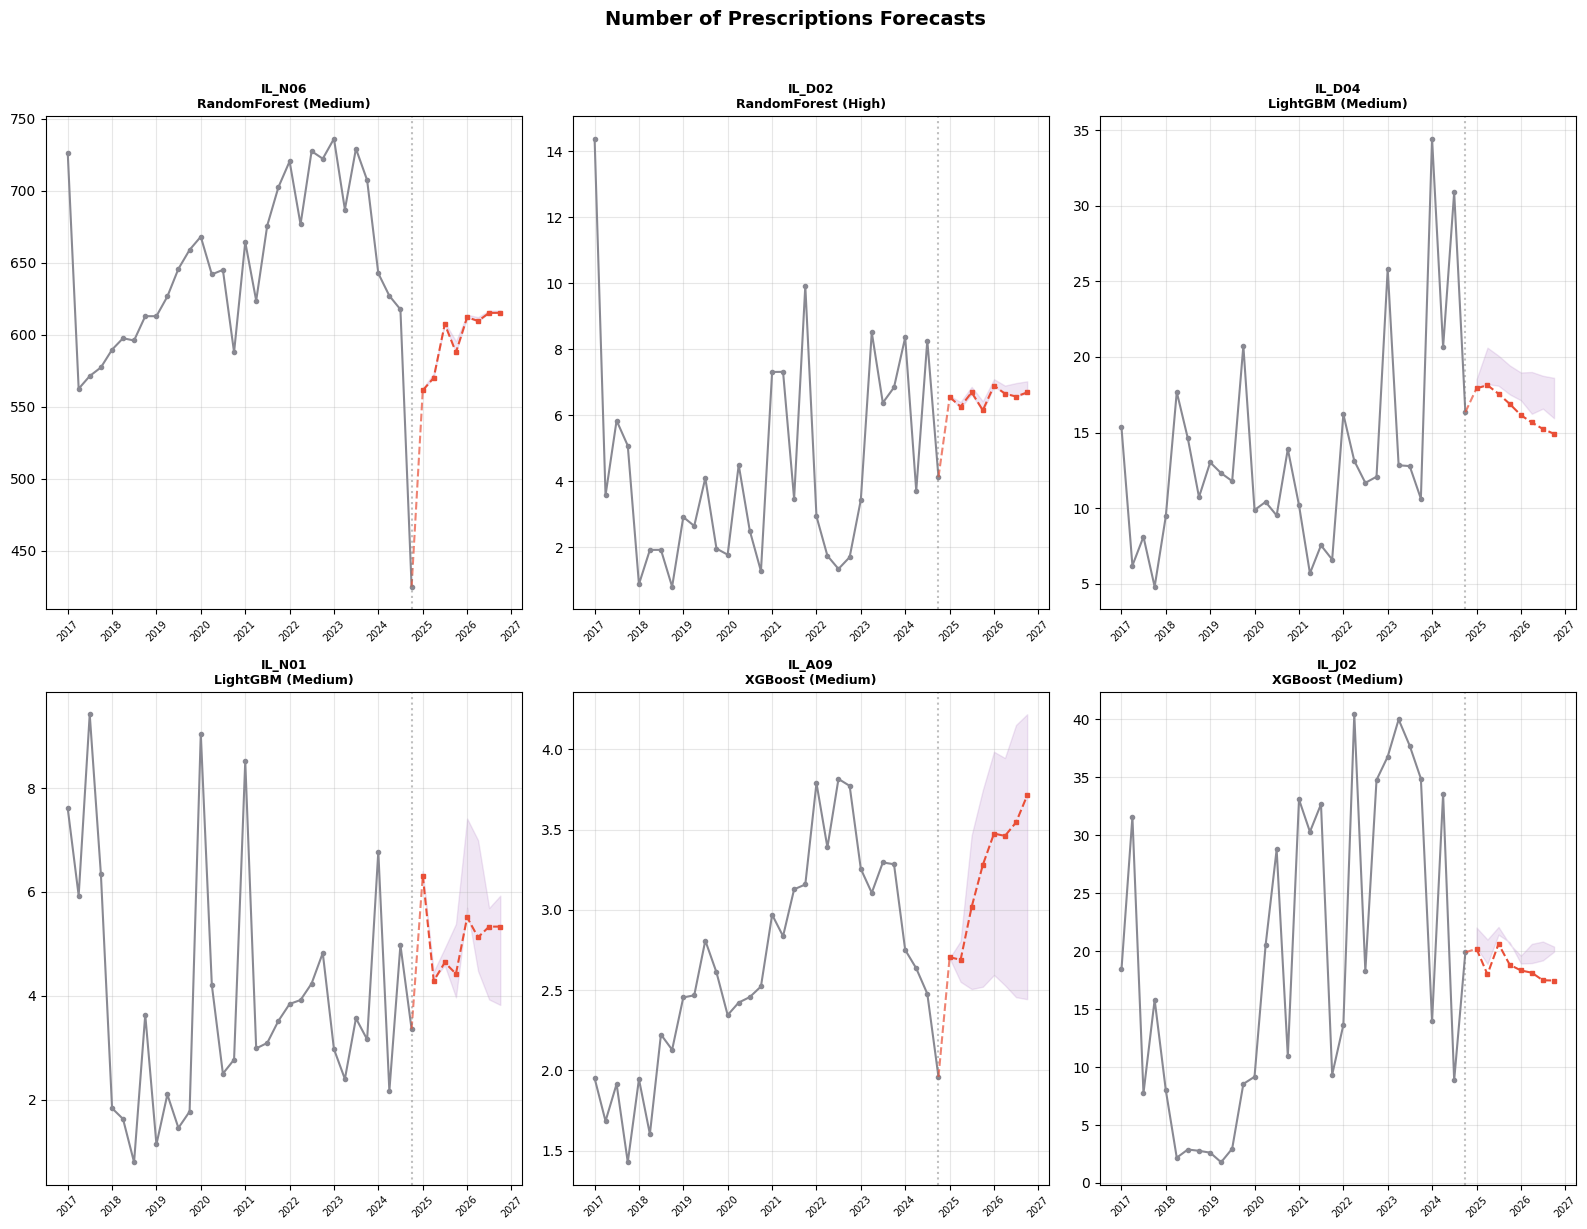

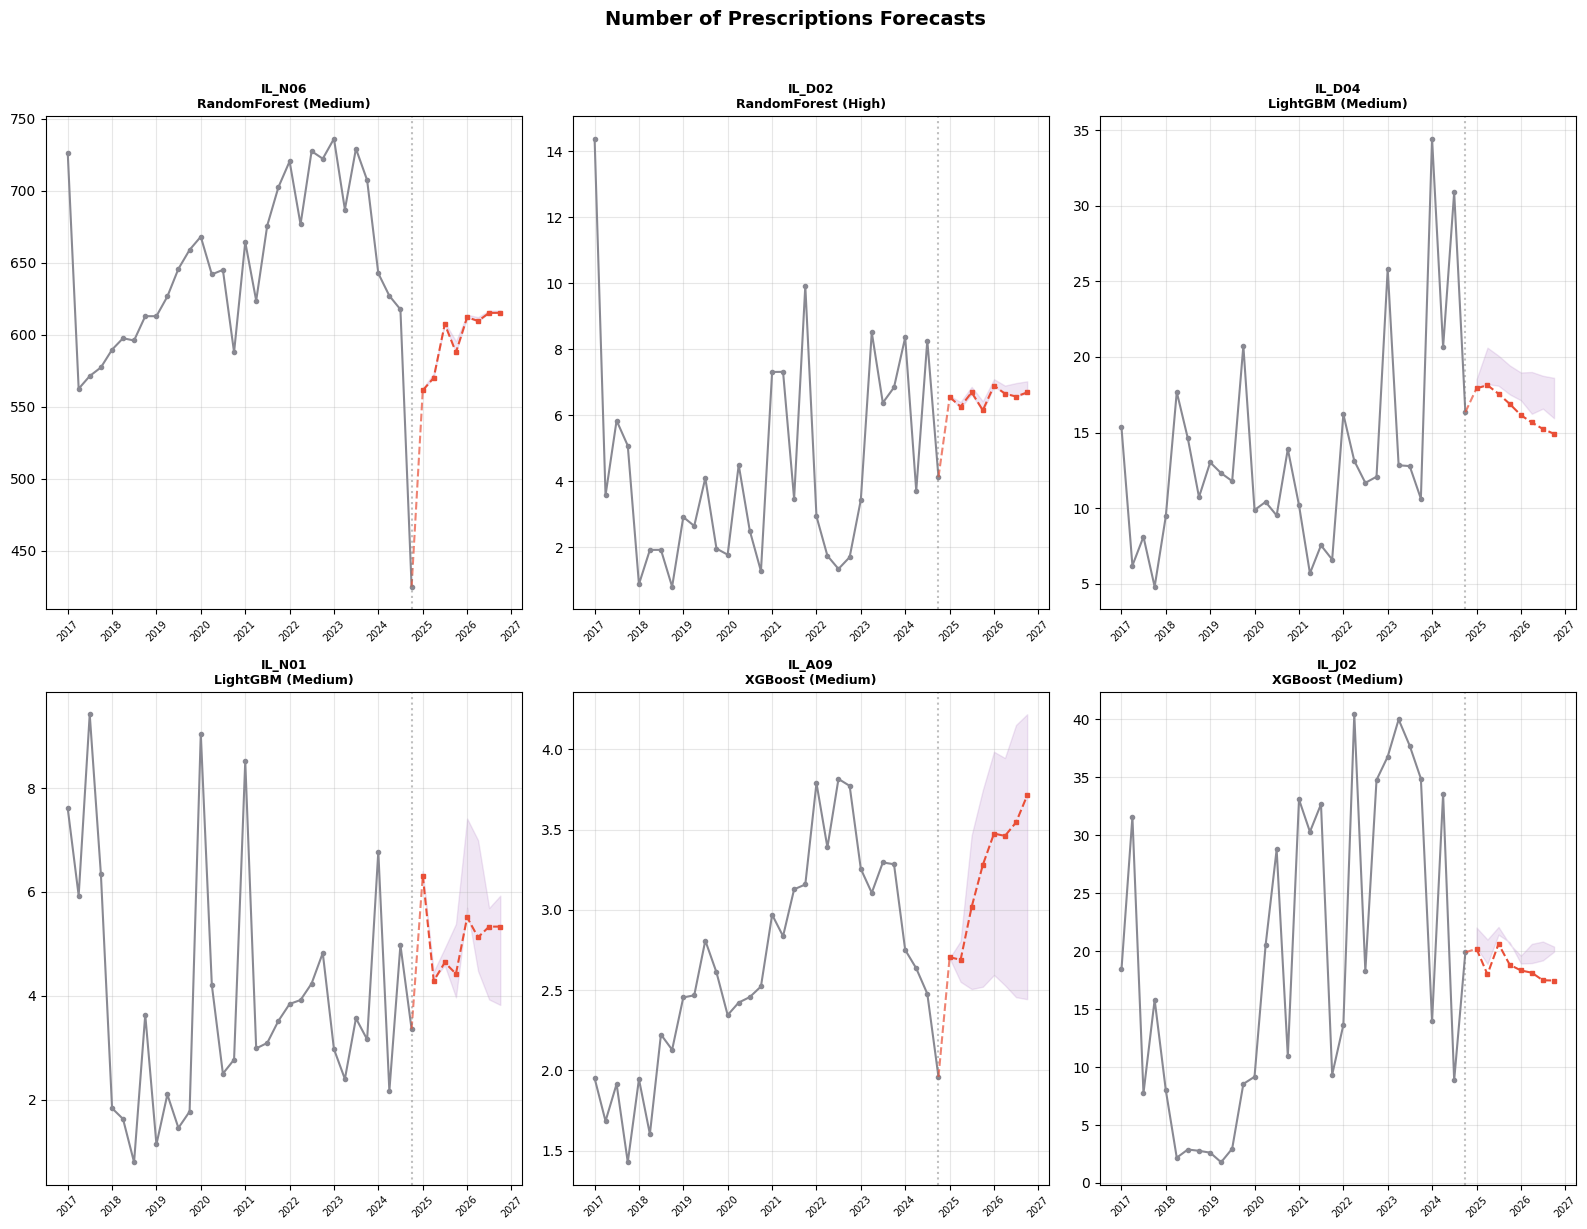

In [224]:
# Plot multiple random series
plot_multiple_forecasts(
    historical_df=results['historical_data'],
    forecast_df=results['combined_forecasts'],
    n_random=6,
    target_name=TARGET_NAME
)